In [1]:
# Jason Hemedinger
# Argonne National Laboratory


In [2]:
import pyart, boto3, tempfile, os, shutil
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from botocore.handlers import disable_signing
from tint import Cell_tracks
from tint import animate as tint_animate
from tint.visualization import embed_mp4_as_gif
from glob import glob
from datetime import datetime


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [3]:
def get_current_scan(station, key_index):
    '''
    Function will pull the latest radar scan from any radar site using 
    Amazon S3.
    ----------
    station = Four letter NEXRAD identifier, must be entered using quote marks
              Example: 'KEPZ'
            
    key_index = Number of keys you want pulled. 
                If a positive number then the number of keys pulled will start from the first key of the day.
                If a negative number then the number of keys pulled will count backwards from most recent key.
                Example: 15 would pull the first 15 keys for the day, while -15 would
                pull the 15 most recent keys
    '''
    #creating a bucket and a client to be able to pull data from AWS and setting 
    #it as unsigned
    bucket = 'noaa-nexrad-level2'
    s3 = boto3.resource('s3')
    s3.meta.client.meta.events.register('choose-signer.s3.*', disable_signing)
    
    #connects the bucket create above with radar data
    aws_radar = s3.Bucket(bucket)
    
    #setting the date and time to current.
    #this will allow for allow the current date's radar scands to be pulled
    desired_datetime = datetime.utcnow()
    target_string = datetime.strftime(desired_datetime, '%Y/%m/%d/'+station)
    
    for obj in aws_radar.objects.filter(Prefix= target_string):
        '{0}:{1}'.format(aws_radar.name, obj.key)
    my_list_of_keys = [this_object.key for this_object in aws_radar.objects.filter(Prefix= target_string)]
    keys = my_list_of_keys[key_index:]
    print(my_list_of_keys[key_index:])
    
    return aws_radar, keys

In [4]:
#creating a new directory for each day of an event
path = '/home/jhemedinger/suli_projects/chicago-nowcast/events'
date = datetime.utcnow().strftime('%Y_%m_%d')
date = str(date)
out_dir_path = path+'/'+date
out_dir = os.makedirs(out_dir_path, exist_ok=True)

#within the newly created directory, creating a directory for each event
event_date = datetime.utcnow().strftime('%Y%m%d-%H')
event_date = str(event_date)
out_path_dir = path+'/'+date+'/'+event_date+'Z'
out_path = os.makedirs(out_path_dir, exist_ok=True)

In [5]:
#setting the radar site and which keys to pull.
aws_radar, keys = get_current_scan('KLOT', key_index=-10)

['2018/06/12/KLOT/KLOT20180612_172105_V06', '2018/06/12/KLOT/KLOT20180612_173052_V06', '2018/06/12/KLOT/KLOT20180612_174039_V06', '2018/06/12/KLOT/KLOT20180612_175025_V06', '2018/06/12/KLOT/KLOT20180612_180012_V06', '2018/06/12/KLOT/KLOT20180612_180958_V06', '2018/06/12/KLOT/KLOT20180612_181945_V06', '2018/06/12/KLOT/KLOT20180612_182931_V06', '2018/06/12/KLOT/KLOT20180612_183918_V06', '2018/06/12/KLOT/KLOT20180612_184905_V06']


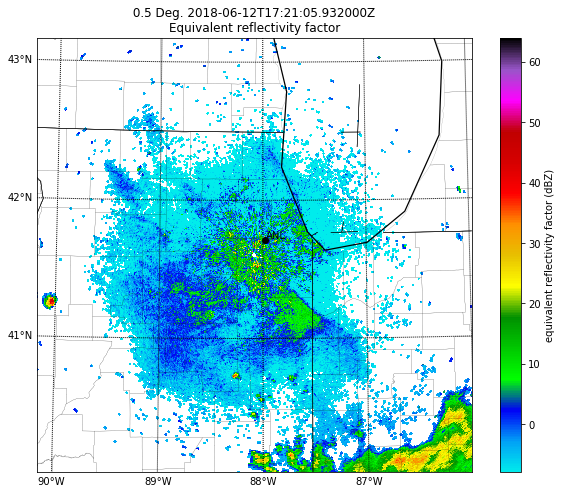

In [6]:
#animating using matplotlib and pyart
def animate(nframe):
    plt.clf()
    localfile = tempfile.NamedTemporaryFile()
    aws_radar.download_file(keys[nframe], localfile.name)
    radar = pyart.io.read(localfile.name)
    display = pyart.graph.RadarMapDisplay(radar)
    # Delete radar after use to save memory.
    del radar
    display.plot_ppi_map('reflectivity', sweep=0, resolution='l',
                         vmin=-8, vmax=64, mask_outside=False, 
                         fig=fig, width=350000, height=350000)
    display.basemap.drawcounties()
    display.plot_point(-87.981810, 41.713969 , label_text='ANL', color='k')
fig = plt.figure(figsize=(10, 8))
anim_klot = animation.FuncAnimation(fig, animate,
                                    frames=len(keys))
anim_klot.save(out_path_dir+'/reflectivity_animation.gif',
               writer='imagemagick', fps=2)
plt.show()
plt.close()

In [7]:
#turing the data into grid data and saving it to a folder
def get_grid(aws_radar, key):
    localfile = tempfile.NamedTemporaryFile()
    aws_radar.download_file(key, localfile.name)
    radar = pyart.io.read(localfile.name)
    grid = pyart.map.grid_from_radars(
            radar, grid_shape=(31, 401, 401),
            grid_limits=((0, 15000), (-200000, 200000), (-200000, 200000)),
            fields=['reflectivity'], gridding_algo='map_gates_to_grid',
            h_factor=0., nb=0.6, bsp=1., min_radius=200.)
    return grid

for num,key in enumerate(keys):
    print('saving grid', num)
    grid = get_grid(aws_radar, key)
    name = os.path.join(out_path_dir, 'grid_' + str(num).zfill(3) + '.nc')
    pyart.io.write_grid(name, grid)
    del grid

saving grid 0
saving grid 1
saving grid 2
saving grid 3
saving grid 4
saving grid 5
saving grid 6
saving grid 7
saving grid 8
saving grid 9


In [8]:
#files_2 = [os.path.join(out_dir, fn) for fn in os.listdir(out_dir)]
files = glob(out_path_dir + '/grid_*')

In [9]:
grid_gen = (pyart.io.read_grid(f) for f in files)
#grid_list = [pyart.io.read_grid(f) for f in files]

In [10]:
tracks_obj = Cell_tracks()
tracks_obj.get_tracks(grid_gen)

Writing tracks for scan 0
Writing tracks for scan 1
Writing tracks for scan 2
Writing tracks for scan 3
Writing tracks for scan 4
Writing tracks for scan 5
No cells found in scan 6
Writing tracks for scan 7
Writing tracks for scan 8
Writing tracks for scan 9


time elapsed 0.1 minutes


In [11]:
tracks_obj.tracks

time   grid_x   grid_y      lon      lat  area    vol  \
scan uid                                                                        
0    0   2018-06-12 18:00:12  250.375   92.250 -87.4920  40.6316  24.0   68.5   
     1   2018-06-12 18:00:12  213.703   95.081 -87.9185  40.6600  37.0  100.0   
     2   2018-06-12 18:00:12  230.636   94.091 -87.7170  40.6506  11.0   23.5   
1    3   2018-06-12 18:39:18  237.375   91.375 -87.6461  40.6233   8.0   11.5   
     4   2018-06-12 18:39:18   44.545  141.727 -89.9335  41.0680  22.0   48.5   
2    5   2018-06-12 17:50:25  243.792   93.917 -87.5629  40.6500  24.0   60.0   
     6   2018-06-12 17:50:25  207.824   95.794 -87.9896  40.6691  34.0  101.0   
     7   2018-06-12 17:50:25  226.167   94.917 -87.7762  40.6597  12.0   34.5   
3    8   2018-06-12 18:29:31  285.812   79.188 -87.0672  40.5117  16.0   36.5   
     9   2018-06-12 18:29:31   41.268  144.683 -89.9819  41.0941  41.0  100.0   
4    10  2018-06-12 17:40:39  238.500   95.000 -87.6340  40.6593  16.0   35.5   
     11  2018-06-12 17:40:39  202.233   96.767 -88.0607  40.6781  30.0  103.5   
     12  2018-06-12 17:40:39  194.471  100.529 -88.1556  40.7141  17.0   27.0   
5    13  2018-06-12 18:09:58  275.556   82.889 -87.1850  40.5487   9.0   22.5   
     14  2018-06-12 18:09:58  256.400   91.200 -87.4210  40.6223  20.0   42.5   
     15  2018-06-12 18:09:58  221.273   93.500 -87.8355  40.6509  22.0   51.5   
     16  2018-06-12 18:09:58   33.205  151.231 -90.0790  41.1465  39.0  155.0   
     17  2018-06-12 18:09:58   42.500  151.000 -89.9716  41.1483  14.0   39.0   
7    18  2018-06-12 17:30:52  198.778   96.741 -88.0963  40.6781  27.0   66.0   
     19  2018-06-12 17:30:52  189.357  101.286 -88.2149  40.7140  14.0   25.0   
     20  2018-06-12 17:30:52    5.615  172.538 -90.4084  41.3382  13.0   26.0   
8    21  2018-06-12 17:21:05  317.727   34.318 -86.6971  40.1031  22.0   53.5   
     19  2018-06-12 17:21:05  184.889  102.111 -88.2624  40.7230   9.0   15.5   
     22  2018-06-12 17:21:05   36.500  163.000 -90.0465  41.2550  16.0   47.0   
     20  2018-06-12 17:21:05    3.435  174.435 -90.4447  41.3464  23.0   69.5   
9    23  2018-06-12 18:19:45  279.611   81.889 -87.1378  40.5393  18.0   39.0   
     24  2018-06-12 18:19:45  263.000   89.083 -87.3382  40.6038  12.0   22.5   
     25  2018-06-12 18:19:45  227.300   92.800 -87.7645  40.6417  10.0   21.0   
     26  2018-06-12 18:19:45   38.780  147.881 -90.0066  41.1207  59.0  185.0   

                max  max_alt  isolated  
scan uid                                
0    0    45.668182      4.5      True  
     1    43.216084      6.0     False  
     2    42.869762      4.0     False  
1    3    34.339287      4.0      True  
     4    35.930504      4.0      True  
2    5    46.506256      4.5      True  
     6    46.294369      6.0     False  
     7    47.015900      6.0     False  
3    8    41.220253      3.5      True  
     9    41.188900      4.5      True  
4    10   43.199371      4.5      True  
     11   52.019455      5.5     False  
     12   37.783611      3.5     False  
5    13   38.716850      5.5      True  
     14   41.131676      4.5      True  
     15   41.865765      4.0      True  
     16   46.292446      7.0     False  
     17   47.168594      6.5     False  
7    18   48.044998      6.0     False  
     19   41.080460      5.5     False  
     20   34.863922      5.0      True  
8    21   34.710442      5.0     False  
     19   38.403111      3.5      True  
     22   44.619072      4.5      True  
     20   40.637268      5.0      True  
9    23   39.098614      6.0      True  
     24   38.330345      5.0      True  
     25   37.373596      2.5      True  
     26   46.829029     13.0      True

In [12]:
if os.path.exists(out_path_dir + '/test_animation.mp4'):
    print(out_path_dir + '/test_animation.mp4'
          + ' already exists, removing file')
    os.remove(out_path_dir + '/test_animation.mp4')

In [13]:
grid_gen = (pyart.io.read_grid(f) for f in files)
tint_animate(tracks_obj, grid_gen, os.path.join(out_path_dir, 'test_animation'))

foobar
Animating 10 frames
Frame: 0
reflectivity 3
-8 64
Frame: 1
reflectivity 3
-8 64
Frame: 2
reflectivity 3
-8 64
Frame: 3
reflectivity 3
-8 64
Frame: 4
reflectivity 3
-8 64
Frame: 5
reflectivity 3
-8 64
Frame: 6
reflectivity 3
-8 64
Frame: 7
reflectivity 3
-8 64
Frame: 8
reflectivity 3
-8 64
Frame: 9
reflectivity 3
-8 64


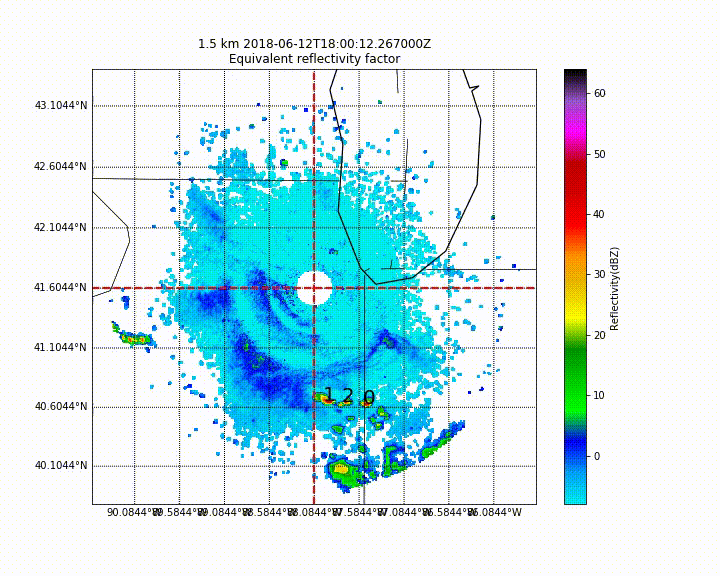

In [14]:
embed_mp4_as_gif(out_path_dir + '/test_animation.mp4')